<a href="https://colab.research.google.com/github/ToluGb/Hamoye-DSI-2020/blob/master/kaggle_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Planet: Understanding the Amazon from Space**

Use satellite data to track human footprint in the Amazon rainforest

Every minute, the world loses an area of forest the size of 48 football fields. And deforestation in the Amazon Basin accounts for the largest share, contributing to reduced biodiversity, habitat loss, climate change, and other devastating effects. But better data about the location of deforestation and human encroachment on forests can help governments and local stakeholders respond more quickly and effectively.

Planet, designer and builder of the world’s largest constellation of Earth-imaging satellites, will soon be collecting daily imagery of the entire land surface of the earth at 3-5 meter resolution. While considerable research has been devoted to tracking changes in forests, it typically depends on coarse-resolution imagery from Landsat (30 meter pixels) or MODIS (250 meter pixels). This limits its effectiveness in areas where small-scale deforestation or forest degradation dominate.

Furthermore, these existing methods generally cannot differentiate between human causes of forest loss and natural causes. Higher resolution imagery has already been shown to be exceptionally good at this, but robust methods have not yet been developed for Planet imagery.

In this competition, Planet and its Brazilian partner SCCON are challenging Kagglers to label satellite image chips with atmospheric conditions and various classes of land cover/land use. Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond.

Submissions will be evaluated based on their mean (F_{2}) score. The F score, commonly used in information retrieval, measures accuracy using the precision p and recall r. Precision is the ratio of true positives (tp) to all predicted positives (tp + fp). Recall is the ratio of true positives to all actual positives (tp + fn). 

In [ ]:
# Importing the relevant libraries and packages
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
from keras.applications import VGG16
from tqdm import tqdm
from keras import backend as K

In [ ]:
df_train = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [ ]:
# F-beta Score

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2
    
    # Just in case of hipstar activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)
    
    # Shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [ ]:
save_best_check_point = ModelCheckpoint(filepath='best_model.hdf5', monitor='val_fbeta', \
                                        mode='max', save_best_only=True, save_weights_only=True)

In [ ]:
train_jpg = '../input/planets-dataset/planet/planet/train-jpg'

In [ ]:
# creating modified DataFrame to implement 'flow_from_dataframe' processing

changed_df = df_train.copy()
changed_df['image_path'] = train_jpg + '/' + changed_df['image_name'] +".jpg" 
changed_df.head()

,image_name,tags,image_path
0,train_0,haze primary,../input/planets-dataset/planet/planet/train-j...
1,train_1,agriculture clear primary water,../input/planets-dataset/planet/planet/train-j...
2,train_2,clear primary,../input/planets-dataset/planet/planet/train-j...
3,train_3,clear primary,../input/planets-dataset/planet/planet/train-j...
4,train_4,agriculture clear habitation primary road,../input/planets-dataset/planet/planet/train-j...


In [ ]:
# create a mapping of tags to integers given the loaded mapping file

def create_tag_mapping(df_train):
    # create a set of all known tags
    labels = set()
    for i in range(len(df_train)):
        # convert spaced separated tags into an array of tags
        tags = df_train['tags'][i].split(' ')
        # add tags to the set of known labels
        labels.update(tags)
        
    # convert set of labels to a list to list
    labels = list(labels)
    # order set alphabetically
    labels.sort()
    # dict that maps labels to integers, and the reverse
    labels_map = {labels[i]:i for i in range(len(labels))}
    inv_labels_map = {i:labels[i] for i in range(len(labels))}
    return labels_map, inv_labels_map

# create a mapping of tags to integers
mapping, inv_mapping = create_tag_mapping(df_train)
print(len(mapping))
print(mapping)

17
{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}


In [ ]:
# OneHot encode the tags
for label in mapping.keys():
    changed_df[label] = changed_df['tags'].apply(lambda x:1 if label in x.split(' ') else 0)
changed_df.head()

,image_name,tags,image_path,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0,haze primary,../input/planets-dataset/planet/planet/train-j...,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,agriculture clear primary water,../input/planets-dataset/planet/planet/train-j...,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2,clear primary,../input/planets-dataset/planet/planet/train-j...,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3,clear primary,../input/planets-dataset/planet/planet/train-j...,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4,agriculture clear habitation primary road,../input/planets-dataset/planet/planet/train-j...,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


In [ ]:
# flow from DataFrame

from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=180,
                                   horizontal_flip=True, 
                                   vertical_flip=True,
                                   validation_split=0.2,
                                   fill_mode = 'reflect' )

val_data_gen = ImageDataGenerator(rescale= 1./255, validation_split=0.2)

train_data =train_datagen.flow_from_dataframe(dataframe=changed_df,
                                              x_col="image_path",
                                              y_col=mapping.keys(),
                                              seed=231,
                                              shuffle=True,
                                              class_mode="raw",
                                              batch_size=128,
                                              target_size=(128,128),
                                              subset="training")

validation_data =train_datagen.flow_from_dataframe(dataframe=changed_df,
                                                   x_col="image_path",
                                                   y_col=mapping.keys(),
                                                   seed=231,
                                                   shuffle=True,
                                                   class_mode="raw",
                                                   batch_size=128,
                                                   target_size=(128,128),
                                                   subset="validation")

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [ ]:
# setting step size for training and validation image data
step_train_size = int(np.ceil(train_data.samples / train_data.batch_size))
step_val_size = int(np.ceil(validation_data.samples / train_data.batch_size))

In [ ]:
import matplotlib.pyplot as plt
def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [ ]:
# VGG Model Architecture

from keras.optimizers import Adam
optimizer = Adam(0.003, decay=0.0005)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False
    
    VGG_model = Sequential([
    base_model,
 
    Flatten(), 
        
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(17, activation='sigmoid')  
])

VGG_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta])
VGG_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_18 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 17)                2193      
Total params: 15,765,585
Trainable params: 1,050,897
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model = VGG_model.fit(train_data,
                             steps_per_epoch=step_train_size,
                             validation_data=validation_data,
                             validation_steps=step_val_size,
                             batch_size=128,
                             epochs=5,
                             verbose=1,
                             callbacks=[save_best_check_point]
                            )

Epoch 1/5
253/253 [==============================] - 295s 1s/step - loss: 0.1991 - fbeta: 0.7231 - val_loss: 0.1577 - val_fbeta: 0.7718
Epoch 2/5
253/253 [==============================] - 270s 1s/step - loss: 0.1613 - fbeta: 0.7663 - val_loss: 0.1486 - val_fbeta: 0.7763
Epoch 3/5
253/253 [==============================] - 272s 1s/step - loss: 0.1547 - fbeta: 0.7747 - val_loss: 0.1431 - val_fbeta: 0.7864
Epoch 4/5
253/253 [==============================] - 272s 1s/step - loss: 0.1507 - fbeta: 0.7834 - val_loss: 0.1434 - val_fbeta: 0.7723
Epoch 5/5
253/253 [==============================] - 272s 1s/step - loss: 0.1488 - fbeta: 0.7865 - val_loss: 0.1454 - val_fbeta: 0.8013


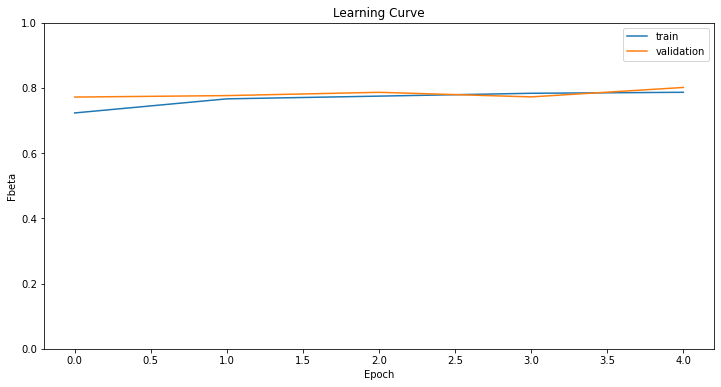

In [ ]:
learning_curve(model, key='fbeta', ylim=(0, 1))

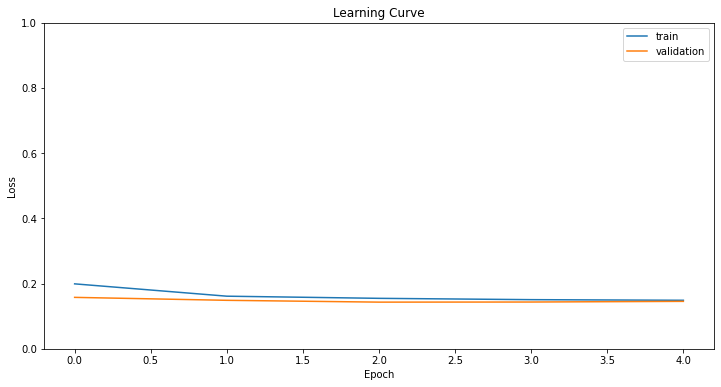

In [ ]:
learning_curve(model, key='loss', ylim=(0, 1))

In [ ]:
sample_submission_df = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [ ]:
# adding .jpg extension to 'image_name' in sample_submission data
sample_submission = sample_submission_df.copy()
sample_submission['image_name'] = sample_submission['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [ ]:
# selecting the first 40669 'image_name'(s) from the submission_sample dataframe to generate image data from 
# test.jpg folder
test1_df = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)
test1_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [ ]:
# initializing an image data generator object for the first 40669 images in the sample submission dataframe
test_image_gen1 = ImageDataGenerator(rescale=1/255)

# generating the image data for the first 40669 images in the sample submission dataframe
test_gen1 = test_image_gen1.flow_from_dataframe(dataframe=test1_df, \
            directory='../input/planets-dataset/planet/planet/test-jpg/', x_col='image_name', y_col=None, \
            batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the first 40669 images in the sample submission dataframe
step_test_size1 = int(np.ceil(test_gen1.samples / test_gen1.batch_size))

Found 40669 validated image filenames.


In [ ]:
# VGG model for test set
from keras.optimizers import Adam
optimizer = Adam(0.003, decay=0.0005)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False
    
    test_model = Sequential([
    base_model,
 
    Flatten(), 
        
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(17, activation='sigmoid')  
])

test_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta])

#loading in the weights of the trained VGG model
test_model.load_weights('best_model.hdf5')

In [ ]:
test_gen1.reset() # reseting the generator to be sure of avoiding shuffling
pred1 = test_model.predict(test_gen1, steps=step_test_size1, verbose=1) # predicts the first 40669 images in the 
                                                                    # sample submission dataframe

318/318 [==============================] - 162s 510ms/step


In [ ]:
unique_labels = set()
def append_labels(tags):
    for tag in tags.split():
        unique_labels.add(tag)

df_train = df_train.copy()
df_train['tags'].apply(append_labels)
unique_labels = list(unique_labels)
unique_labels.sort()
print(unique_labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


In [ ]:
test_file_names1 = test_gen1.filenames # storing the filenames (images names) of the first 40669 images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the first 40669 to tag names
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

# converting the predictions of the first 40669 to a dataframe
result1 = pd.DataFrame({'image_name': test_file_names1, 'tags': pred_tags1})
result1.head()

,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,clear primary
4,test_4.jpg,partly_cloudy primary


In [ ]:
# selecting the remaining 'image_name'(s) from the submission_sample dataframe to generate image data from 
# test-additional.jpg folder
test2_df = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
test2_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [ ]:
# initializing an image data generator object for the remaining images in the sample submission dataframe
test_image_gen2 = ImageDataGenerator(rescale=1/255)

# generating the image data for the remaining images in the sample submission dataframe
test_gen2 = test_image_gen2.flow_from_dataframe(dataframe=test2_df, \
            directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional/', x_col='image_name', \
            y_col=None, batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the remaining images in the sample submission dataframe
step_test_size2 = int(np.ceil(test_gen2.samples / test_gen2.batch_size))

Found 20522 validated image filenames.


In [ ]:
test_gen2.reset() # reseting the generator to be sure of avoiding shuffling
pred2 = test_model.predict(test_gen2, steps=step_test_size2, verbose=1) # predicts the remaining images in the 
                                                                    # sample submission dataframe

161/161 [==============================] - 84s 519ms/step


In [ ]:
test_file_names2 = test_gen2.filenames # storing the filenames (images names) of the remaining images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the remaining images to tag names
pred_tags2 = pd.DataFrame(pred2)
pred_tags2 = pred_tags2.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

# converting the predictions of the remaining to a dataframe
result2 = pd.DataFrame({'image_name': test_file_names2, 'tags': pred_tags2})
result2.head()

,image_name,tags
0,file_0.jpg,clear primary
1,file_1.jpg,agriculture clear habitation primary road
2,file_10.jpg,clear primary water
3,file_100.jpg,agriculture clear primary
4,file_1000.jpg,clear primary


In [ ]:
final_result = pd.concat([result1, result2]) # concatenate the predictions of the test.jpg and 
                                             # test-additional.jpg into a single dataframe
    
final_result = final_result.reset_index().drop('index', axis=1) # reseting the index of the dataframe so it 
                                                                # matches that of sample submission datafarme

print(final_result.shape)
final_result.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,clear primary
4,test_4.jpg,partly_cloudy primary


In [ ]:
# confirming that the predicted images are ordered as in sample submission dataframe
assert sum(sample_submission['image_name'] == final_result['image_name']) == 61191

In [ ]:
# removing the .jpg extension from 'iamge_name' column
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear primary
4,test_4,partly_cloudy primary


In [ ]:
final_result.to_csv('second_submission.csv', index=False) # saving the predictions